In [133]:
import numpy as np
import pandas as pd
import pickle
import time
from loadData_adult import load_data
from normalizeData import normalize_data
from projectData import project_data
from fairPCA import fair_pca
from lloyd import lloyd
from giveRandCenters import give_rand_centers
from findClustering import find_clustering
from compCost import comp_cost
from kmeans_explainer import CFE_explainer
from collections import defaultdict
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans
import scipy.io
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from collections import defaultdict
import seaborn as sns


## Load dataset, results

In [53]:
df = pd.read_csv('adult_violating_labeled_5.csv')
data = scipy.io.loadmat('results_fair_clustering_adult_5.mat')
clustering = scipy.io.loadmat('unfair_clustering_adult_5.mat')
data.keys()
centersN = data['centersN'][4][0]
centersNF = data['centersNF'][4][0]
unfair_clustering = data['clusteringN'][4][0]
unfair_clustering = unfair_clustering - 1
unfair_clustering = np.array(unfair_clustering)
unfair_clustering = unfair_clustering.flatten()
fair_clustering = data['fair_clustering_combined'].flatten()
fair_clustering = fair_clustering - 1

unfair_cost = data['CostN'][4][0]
fair_cost = data['CostNF'][4][0]
females = data['data_females']
males = data['data_males']
combined_data = np.vstack([females, males])
print("Unfair cost (Female):", unfair_cost[0])
print("Unfair cost (Male):", unfair_cost[1])
print("Fair cost (Female):", fair_cost[0])
print("Fair cost (Male):", fair_cost[1])

Unfair cost (Female): [6.83298083]
Unfair cost (Male): [5.45763923]
Fair cost (Female): [6.21258567]
Fair cost (Male): [6.21258567]


In [55]:
fair_clustering_females = data['clusteringNF'][4][0][0][0].flatten()
fair_clustering_males   = data['clusteringNF'][4][0][0][1].flatten()

female_indices = df[df['sex'] == 0].index.values
male_indices   = df[df['sex'] == 1].index.values

In [59]:
start_col = 'race'
cols_to_drop = df.columns[df.columns.get_loc(start_col):]
df_filtered = df.drop(columns=cols_to_drop)


## Apply Silhouette Coefficient

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Window

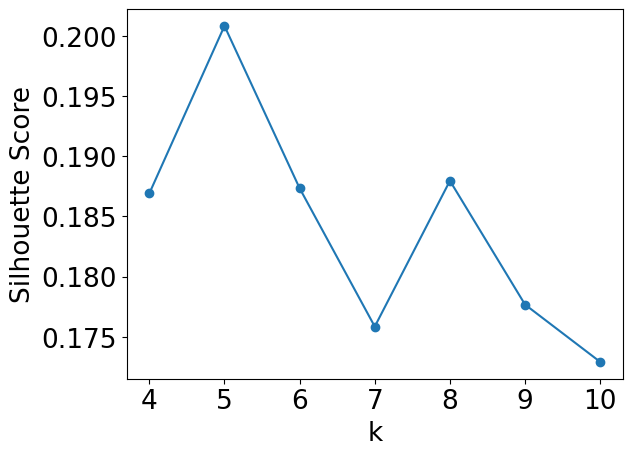

In [62]:
silhouette_scores = []
k_values = range(4, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_filtered)
    score = silhouette_score(df_filtered, labels)
    silhouette_scores.append(score)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
# Plotting the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('k',fontsize=19)
plt.ylabel('Silhouette Score',fontsize=19)
plt.savefig("Silhouette_adult.pdf")

plt.show()


In [32]:
female_indices = df[df['sex'] == 0].index.values
male_indices   = df[df['sex'] == 1].index.values

female_unfair_labels = unfair_clustering[female_indices]
male_unfair_labels = unfair_clustering[male_indices]


# Assign unfair labels
df.loc[female_indices, 'unfair_label'] = unfair_clustering[female_indices]
df.loc[male_indices, 'unfair_label'] = unfair_clustering[male_indices]

# Assign fair labels (from fair_clustering split by sex)
df.loc[female_indices, 'fair_label'] = fair_clustering_females
df.loc[male_indices, 'fair_label'] = fair_clustering_males


In [68]:
unique_unfair, counts_unfair = np.unique(unfair_clustering, return_counts=True)
unique_fair, counts_fair = np.unique(fair_clustering, return_counts=True)
label_counts_unfair = dict(zip(unique_unfair, counts_unfair))
print("Unfair clustering",label_counts_unfair)
label_counts = dict(zip(unique_fair, counts_fair))
print("Fair clustering",label_counts)

Unfair clustering {0.0: 221, 1.0: 52, 2.0: 373, 3.0: 350, 4.0: 4}
Fair clustering {0.0: 222, 1.0: 52, 2.0: 372, 3.0: 350, 4.0: 4}


In [76]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Apply PCA to reduce data to 2D for visualization
# pca = PCA(n_components=2)
# data_2d = pca.fit_transform(combined_data)

# unfair_centers = pca.transform(centersN)
# fair_centers = pca.transform(centersNF)
# print('unfair_centers',unfair_centers)
# print('fair_centers',fair_centers)
# # Transform data_group_1 and data_group_2 using the same PCA
# female = pca.transform(females)  # Apply PCA to group 1
# male = pca.transform(males)  # Apply PCA to group 2

# # Compute means AFTER PCA transformation
# mean_A_pca = np.mean(female, axis=0)  
# mean_B_pca = np.mean(male, axis=0)


# # Plot the unfair clustering
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.scatter(data_2d[:, 0], data_2d[:, 1], c=unfair_clustering, cmap='viridis', label='Unfair Clustering')
# plt.scatter(unfair_centers[:, 0], unfair_centers[:, 1], c='red', marker='*', s=200, label='Cluster Centers')
# plt.scatter(mean_A_pca[0], mean_A_pca[1], c='blue', marker='X', s=150, label='Mean A')  # Mean A after PCA
# plt.scatter(mean_B_pca[0], mean_B_pca[1], c='blue', marker='X', s=150, label='Mean B')  # Plot mean_A

# plt.title('Unfair Clustering (PCA projection)')
# plt.colorbar(label='Cluster Label')

# # Plot the aligned fair clustering
# plt.subplot(1, 2, 2)
# plt.scatter(data_2d[:, 0], data_2d[:, 1], c=fair_clustering, cmap='viridis', label='Aligned Fair Clustering')
# plt.scatter(fair_centers[:,0], fair_centers[:, 1], color='red', marker='*', s=200, label='Cluster Centers')
# plt.scatter(mean_A_pca[0], mean_A_pca[1], c='blue', marker='X', s=150, label='Mean A')  # Plot mean_A
# plt.scatter(mean_B_pca[0], mean_B_pca[1], c='blue', marker='X', s=150, label='Mean B')  # Plot mean_A

# plt.title('Fair Clustering (PCA projection)')
# plt.colorbar(label='Cluster Label')

# plt.tight_layout()
# plt.show()


### Cluster Alignment

In [183]:
from scipy.optimize import linear_sum_assignment

def jaccard_similarity(unfair_cluster, fair_cluster, unfair_cluster_id, fair_cluster_id):
    intersection = len(unfair_cluster.intersection(fair_cluster))
    union = len(unfair_cluster.union(fair_cluster))
    return intersection / union if union != 0 else 0


def compute_similarity_matrix(unfair_clusters, fair_clusters):
    m = len(unfair_clusters)
    n = len(fair_clusters)
    
    similarity_matrix = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            similarity_matrix[i, j] = jaccard_similarity(unfair_clusters[i], fair_clusters[j],i,j)
    return similarity_matrix

def align_clusters(unfair_clusters, fair_clusters):
    """Align clusters using the Hungarian algorithm."""
    # Compute similarity matrix
    similarity_matrix = compute_similarity_matrix(unfair_clusters, fair_clusters)
    
    # Convert similarity to cost (cost = 1 - similarity)
    cost_matrix = 1 - similarity_matrix
    
    # Apply the Hungarian algorithm to find the optimal cluster alignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    # Return the optimal cluster alignment
    alignment = {i: col_ind[i] for i in range(len(row_ind))}
    
    return alignment
def get_cluster_sets(labels):
    clusters = defaultdict(set)
    for idx, label in enumerate(labels):
        clusters[int(label)].add(idx)
    return [clusters[i] for i in sorted(clusters)]
cluster_A = get_cluster_sets(unfair_clustering)  # Unfair clustering
cluster_B = get_cluster_sets(fair_clustering)
alignment = align_clusters(cluster_A, cluster_B)
alignment


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

In [86]:
reverse_alignment = {v: k for k, v in alignment.items()}
aligned_fair_labels = [reverse_alignment[label] for label in fair_clustering]
print("Aligned Fair Labels:", aligned_fair_labels)

Aligned Fair Labels: [2, 3, 3, 3, 2, 2, 2, 3, 0, 0, 3, 2, 3, 1, 0, 3, 0, 0, 3, 2, 2, 3, 2, 3, 0, 3, 0, 3, 3, 2, 2, 2, 3, 3, 1, 2, 0, 0, 2, 2, 3, 0, 3, 3, 1, 2, 3, 3, 3, 2, 2, 2, 0, 3, 3, 2, 2, 3, 2, 0, 3, 0, 2, 3, 3, 3, 2, 2, 0, 0, 2, 0, 3, 3, 2, 2, 1, 2, 4, 0, 3, 3, 0, 0, 2, 2, 2, 0, 3, 4, 2, 1, 3, 2, 2, 2, 0, 1, 3, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 0, 0, 3, 2, 0, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 0, 0, 2, 3, 3, 3, 0, 2, 0, 3, 3, 2, 2, 3, 3, 0, 3, 2, 2, 0, 3, 3, 1, 2, 2, 3, 0, 3, 3, 0, 0, 2, 0, 0, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 0, 2, 2, 0, 0, 3, 2, 3, 3, 3, 0, 2, 2, 3, 0, 2, 1, 2, 2, 3, 2, 2, 0, 3, 3, 2, 3, 2, 0, 0, 1, 2, 3, 3, 2, 0, 2, 2, 0, 0, 3, 2, 2, 3, 0, 3, 2, 3, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 3, 2, 3, 2, 2, 3, 2, 0, 0, 0, 0, 2, 2, 3, 3, 2, 3, 2, 0, 2, 3, 0, 2, 3, 0, 0, 3, 1, 2, 0, 0, 2, 2, 1, 3, 2, 2, 0, 3, 3, 3, 3, 0, 0, 3, 0, 2, 3, 0, 0, 0, 2, 2, 3, 0, 0, 2, 3, 2, 2, 3, 3, 3, 3, 0, 3, 2, 2, 0, 2, 3, 3, 3, 3, 1, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 3, 

### Find the misaligned points

In [88]:
misaligned_points = []
for i in range(len(fair_clustering)):
    aligned_label = reverse_alignment[fair_clustering[i]]
    if aligned_label != unfair_clustering[i]:
        misaligned_points.append(i)

print(f"Total misaligned points after fair clustering: {len(misaligned_points)}")
#print("Indices of misaligned points:", misaligned_points)

Total misaligned points after fair clustering: 24


### NMI

In [90]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(unfair_clustering, fair_clustering)
print("NMI between unfair and fair clustering:", nmi)


NMI between unfair and fair clustering: 0.9128542316353806


### Create a dataframe with misaligned points: index, unfair_label, fair_label, sensitive attribute

In [94]:
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment

unfair_labels = np.array(unfair_clustering).flatten()
fair_lloyd_labels = np.array(fair_clustering).flatten()  # From fair Lloyd method

k = len(np.unique(unfair_labels))
conf_matrix = np.zeros((k, k), dtype=int)

for i in range(k):
    for j in range(k):
        conf_matrix[i, j] = np.sum((unfair_labels == i) & (fair_lloyd_labels == j))

row_ind, col_ind = linear_sum_assignment(-conf_matrix)
alignment = dict(zip(col_ind, row_ind))  # Map fair → unfair

aligned_fair_lloyd_labels = np.array([alignment[label] for label in fair_lloyd_labels])

misclassified_indices = np.where(unfair_labels != aligned_fair_lloyd_labels)[0]


df_misclassified = pd.DataFrame({
    "index": misclassified_indices,
    "unfair_label": unfair_labels[misclassified_indices],
    "aligned_fair_label": aligned_fair_lloyd_labels[misclassified_indices],
    "fair_label": fair_lloyd_labels[misclassified_indices],
    "sex": df.loc[misclassified_indices, 'sex'].values.astype(int),
}).reset_index(drop=True)


In [114]:
sex_counts = df_misclassified['sex'].value_counts()

print(f"Female (0): {sex_counts.get(0, 0)}")
print(f"Male   (1): {sex_counts.get(1, 0)}")

Female (0): 16
Male   (1): 8


In [116]:
misclassified_labels = np.full(combined_data.shape[0],-1,dtype=int)
misclassified_labels[misclassified_indices] = df_misclassified['aligned_fair_label']
misclassified_labels = misclassified_labels.reshape(-1, 1)
misclassified_data = np.hstack((combined_data, misclassified_labels))

In [118]:
def split_by_unfair_label(df, label_column="unfair_label"):
    clusters = df[label_column].unique()
    split_dfs = {label: df[df[label_column] == label].reset_index(drop=True) for label in clusters}
    return split_dfs


In [120]:
df_misclassified_by_cluster = split_by_unfair_label(df_misclassified)
for label, df_subset in df_misclassified_by_cluster.items():
    print(f"Unfair Cluster {label} → {df_subset.shape[0]} samples")


Unfair Cluster 2.0 → 12 samples
Unfair Cluster 3.0 → 12 samples


In [106]:
# Print info for each unfair cluster
for label, df_subset in df_misclassified_by_cluster.items():
    total = df_subset.shape[0]
    group_counts = df_subset["sex"].value_counts().to_dict()
    females = group_counts.get(0, 0)
    males = group_counts.get(1, 0)

    print(f"Unfair Cluster {label} → {total} samples")
    print(f"  Females (0): {females}")
    print(f"  Males (1): {males}")


Unfair Cluster 2.0 → 12 samples
  Females (0): 12
  Males (1): 0
Unfair Cluster 3.0 → 12 samples
  Females (0): 4
  Males (1): 8


In [122]:
sex_column = df['sex'].to_numpy().reshape(-1, 1).astype(int)

misclassified_labels = np.full(combined_data.shape[0], -1, dtype=int)
misclassified_labels[misclassified_indices] = df_misclassified['aligned_fair_label']
misclassified_labels = misclassified_labels.reshape(-1, 1)

unfair_labels = np.array(unfair_clustering).reshape(-1, 1)
expected_fair_labels = np.array([alignment[label] for label in unfair_clustering]).reshape(-1, 1)
misclassified_data = np.hstack((
    combined_data,
    sex_column,
    unfair_labels,
    expected_fair_labels,
    misclassified_labels
))

In [124]:
def extract_misclassified_transitions(misclassified_data):
    all_unfair_labels = np.unique(misclassified_data[:, -3]).astype(int)
    all_expected_fair_labels = np.unique(misclassified_data[:, -2])
    all_expected_fair_labels = all_expected_fair_labels[all_expected_fair_labels != -1]
    print("Expected fair labels found:", all_expected_fair_labels)
    
    misclassified_by_transition = defaultdict(list)    
    misclassified_by_transition_and_group = defaultdict(lambda: defaultdict(list))
    data_per_unfair_cluster = {}

    for unfair_label in all_unfair_labels:
        data_unfair = misclassified_data[misclassified_data[:, -3] == unfair_label]
        data_per_unfair_cluster[unfair_label] = data_unfair[:, :-3]

        misclassified = data_unfair[
            (data_unfair[:, -1] != -1) & (data_unfair[:, -1] != data_unfair[:, -2])
        ]

        print(f"Unfair label {unfair_label} → Misclassified rows: {misclassified.shape[0]}")

        for fair_label in np.unique(misclassified[:, -1]):
            subset = misclassified[misclassified[:, -1] == fair_label]
            key = (int(unfair_label), int(fair_label))
            misclassified_by_transition[key].append(subset[:, :-3])

            for group in np.unique(subset[:, -4]):  # sex should be in -4 if included
                subgroup = subset[subset[:, -4] == group]
                misclassified_by_transition_and_group[key][int(group)].append(subgroup[:, :-3])

    # Final stacking
    for key in misclassified_by_transition:
        misclassified_by_transition[key] = (
            np.vstack(misclassified_by_transition[key]) if misclassified_by_transition[key]
            else np.empty((0, misclassified_data.shape[1] - 3))
        )

    for key in misclassified_by_transition_and_group:
        for group in misclassified_by_transition_and_group[key]:
            items = misclassified_by_transition_and_group[key][group]
            misclassified_by_transition_and_group[key][group] = (
                np.vstack(items) if items else np.empty((0, misclassified_data.shape[1] - 3))
            )

    return misclassified_by_transition, data_per_unfair_cluster, misclassified_by_transition_and_group


In [126]:
misclassified_by_transition, data_per_unfair_cluster, misclassified_by_transition_and_group = extract_misclassified_transitions(misclassified_data)

for (unfair, fair), arr in misclassified_by_transition.items():
    print(f"{unfair} → {fair} | total: {arr.shape[0]}")
for unfair, arr in data_per_unfair_cluster.items():
    print(f"Unfair cluster {unfair} has total {arr.shape[0]} points")


Expected fair labels found: [0. 1. 2. 3. 4.]
Unfair label 0 → Misclassified rows: 0
Unfair label 1 → Misclassified rows: 0
Unfair label 2 → Misclassified rows: 12
Unfair label 3 → Misclassified rows: 12
Unfair label 4 → Misclassified rows: 0
2 → 3 | total: 12
3 → 0 | total: 1
3 → 2 | total: 11
Unfair cluster 0 has total 221 points
Unfair cluster 1 has total 52 points
Unfair cluster 2 has total 373 points
Unfair cluster 3 has total 350 points
Unfair cluster 4 has total 4 points


## Produce counterfactuals

In [131]:
factuals_indices = []
feature_cols = ['age', 'final-weight', 'education-num','marital-status','occupation','relationship', 'capital-gain', 'hours-per-week','native-country','income']
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

gender_list = []
cfes_lists = {}
cf_rows = []
factual_rows = []
mask = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
d_eps_center_dist_ratio = 1.0
distance_dfs = {}
all_distances = []  

for (unfair_label, fair_label), factual_array in misclassified_by_transition.items():
    if factual_array.shape[0] == 0:
        continue
    center_unfair = centersN[unfair_label]
    center_fair = centersN[fair_label]
    explainer = CFE_explainer(center_unfair, center_fair)

    cfes_list = []
    distances = []  # <-- reset inside the loop
    df_cluster = df_misclassified_by_cluster[unfair_label].copy()
    df_cluster = df_cluster[df_cluster['aligned_fair_label'] == fair_label].copy()
    df_cluster = df_cluster.reset_index(drop=True)
    for i, factual in enumerate(factual_array[:,:-1]):
        z_optimal = explainer.compute_counterfactual(factual, mask, d_eps_center_dist_ratio)
        cfes_list.append(z_optimal)
        dist = np.linalg.norm(factual - z_optimal)
        distances.append(dist)
        # For the combined DataFrame later
        factual_rows.append(factual)
        cf_rows.append(z_optimal)
        all_distances.append(dist)  
        factuals_indices.append(df_cluster.loc[i, 'index'])  
        gender_list.append(df_cluster.loc[i, 'sex'])
    cfes_lists[(unfair_label, fair_label)] = cfes_list

    
    df_cluster["distance_cf_squared"] = distances

    if unfair_label not in distance_dfs:
        distance_dfs[unfair_label] = {}
    distance_dfs[unfair_label][fair_label] = df_cluster

# Final merged DataFrame
df_factuals = pd.DataFrame(factual_rows, columns=feature_cols)
df_counterfactuals = pd.DataFrame(cf_rows, columns=cf_feature_cols)
df_factuals_counterfactuals = pd.concat([df_factuals, df_counterfactuals], axis=1)
df_factuals_counterfactuals['distance'] = all_distances
df_factuals_counterfactuals['gender'] = gender_list
df_factuals_counterfactuals['Gender Label'] = df_factuals_counterfactuals['gender'].map({0: 'Female', 1: 'Male'})
df_grouped = df_factuals_counterfactuals.groupby('Gender Label')['distance'].mean().reset_index()

In [135]:
# Plot
# plt.figure(figsize=(10, 8))
# sns.barplot(data=df_grouped, x='Gender Label', y='distance', palette='Set2')

# plt.xticks(fontsize=35)
# plt.yticks(fontsize=35)    
# plt.xlabel("Gender",fontsize=35)
# plt.ylabel("Average Euclidean Distance",fontsize=35)
# plt.tight_layout()
# plt.savefig("average_counterfactual_distance_by_gender_fair_lloyd.pdf", bbox_inches='tight', edgecolor='none', transparent=True)
# plt.show()


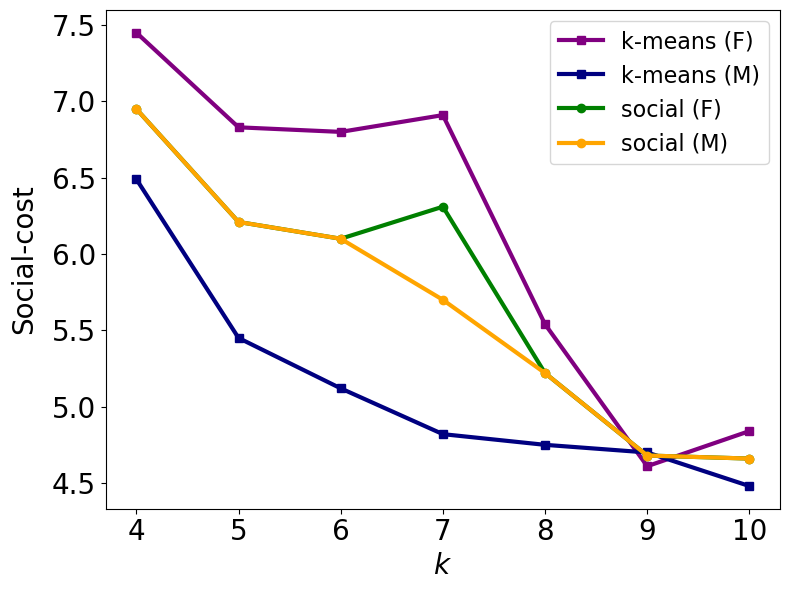

In [137]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
k_values = [4, 5, 6, 7, 8, 9, 10]
lloyd_female = [7.45, 6.83, 6.8, 6.91, 5.54, 4.61, 4.84]
fair_lloyd_female = [6.95, 6.21, 6.1, 6.31, 5.22, 4.68, 4.66]
fair_lloyd_male = [6.95, 6.21, 6.1, 5.7, 5.22, 4.68, 4.66]
lloyd_male = [6.49, 5.45, 5.12, 4.82, 4.75, 4.7, 4.48]

# Plot
plt.figure(figsize=(8,6))

plt.plot(k_values, lloyd_female, color='purple', marker='s', label='k-means (F)', linewidth=3)
plt.plot(k_values, lloyd_male, color='navy',marker='s', label='k-means (M)', linewidth=3)
plt.plot(k_values, fair_lloyd_female, color='green', marker='o', label='social (F)', linewidth=3)
plt.plot(k_values, fair_lloyd_male, color='orange', marker='o', label='social (M)', linewidth=3)

# Axis labels
plt.xlabel(r"$k$",fontsize=20)
plt.ylabel("Social-cost", labelpad=10,fontsize=20)

# Tick sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Legend
plt.legend(fontsize=16)

# Layout
plt.tight_layout()
plt.savefig("cost_per_cluster_fair_lloyd_adult.pdf")
plt.show()


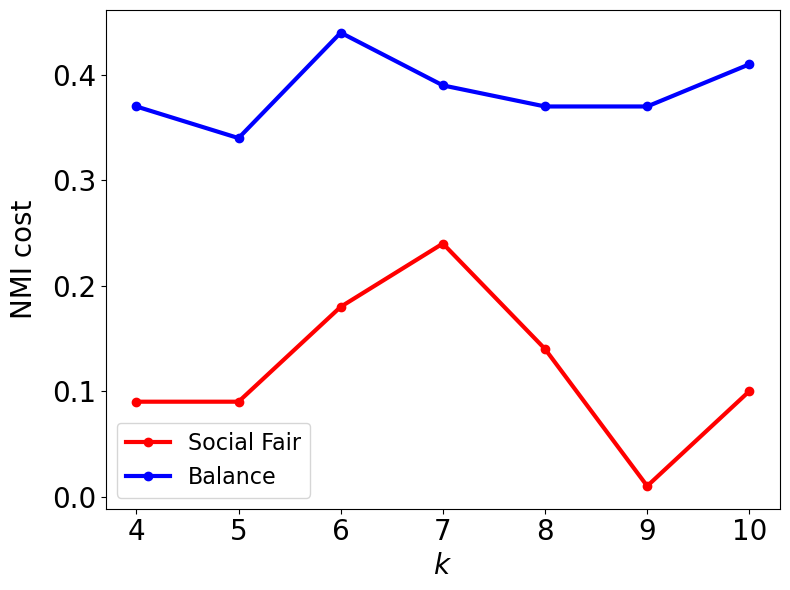

In [215]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
k_values = [4, 5, 6, 7, 8, 9, 10]
nmi_lloyd = [0.91, 0.91, 0.82, 0.76, 0.86, 0.99, 0.90]
nmi_balance = [0.63, 0.66, 0.56, 0.61, 0.63, 0.63, 0.59]

one_minus_nmi_lloyd = [1 - x for x in nmi_lloyd]
one_minus_nmi_balance = [1 - x for x in nmi_balance]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(k_values, one_minus_nmi_lloyd, color='red', label='Social Fair',marker='o', linewidth=3)
plt.plot(k_values, one_minus_nmi_balance, color='blue', label='Balance',marker='o', linewidth=3)

# Axis labels
plt.ylabel("NMI cost", labelpad=10,fontsize=20)
plt.xlabel(r"$k$", fontsize=20)


# Title

# Tick sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Legend
plt.legend(fontsize=16)
# Layout
# Layout
plt.tight_layout()
plt.savefig("nmi_cost_per_cluster_adult.pdf")

plt.show()


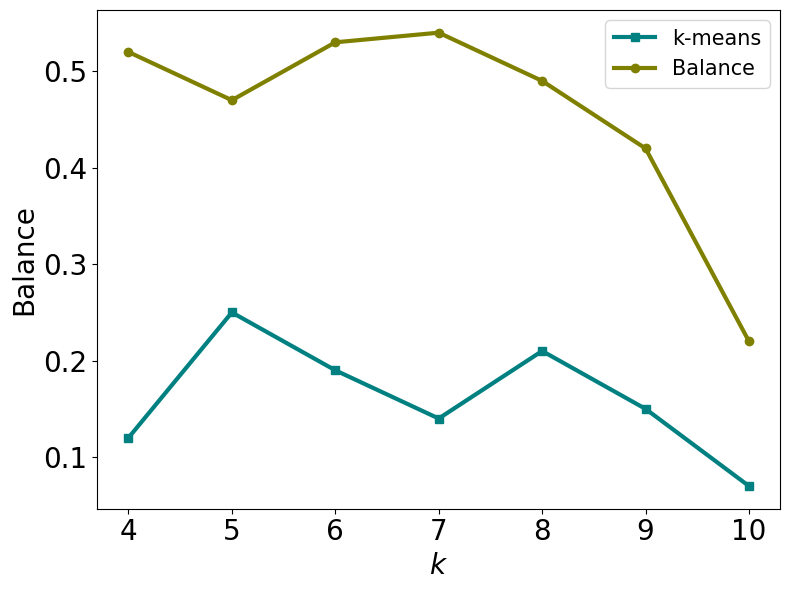

In [460]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
k_values = [4, 5, 6, 7, 8, 9, 10]
unfair_balance = [0.12, 0.25, 0.19, 0.14, 0.21, 0.15, 0.07]
fair_balance = [0.52, 0.47, 0.53, 0.54, 0.49, 0.42, 0.22]

# Plot
plt.figure(figsize=(8,6))
plt.plot(k_values, unfair_balance, color='teal', label='k-means',marker='s', linewidth=3)
plt.plot(k_values, fair_balance, color='olive', label='Balance', marker='o',linewidth=3)

plt.xlabel(r"$k$", fontsize=20)
plt.ylabel("Balance", fontsize=20)

# Tick sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Legend
plt.legend(fontsize=15)
# Layout
plt.tight_layout()
plt.savefig("balance_per_cluster_adult.pdf")

plt.show()


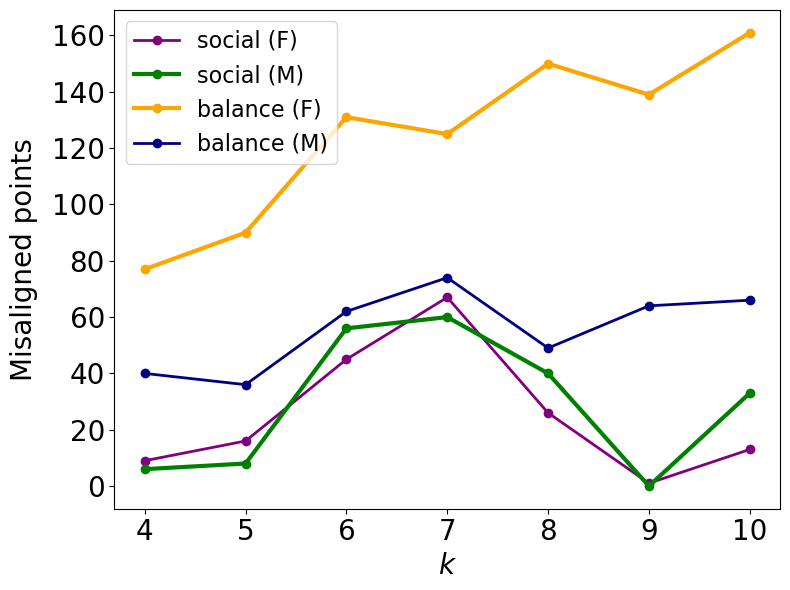

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
k_values = [4, 5, 6, 7, 8, 9, 10]
mis_fl_female = [9,16,45,67,26,1,13]
mis_fl_male = [6,8,56,60,40,0,33]
mis_b_female = [77,90,131,125,150,139,161]
mis_b_male = [40,36,62,74,49,64,66]

df = pd.DataFrame({
    'k': k_values,
    'mis_fl_female': mis_fl_female,
    'mis_fl_male': mis_fl_male,
    'mis_b_female': mis_b_female,
    'mis_b_male': mis_b_male
})

# Plot
plt.figure(figsize=(8,6))

plt.plot(k_values, mis_fl_female, color='purple', marker='o', label='social (F)', linewidth=2)
plt.plot(k_values, mis_fl_male, color='green', marker='o', label='social (M)', linewidth=3)
plt.plot(k_values, mis_b_female, color='orange', marker='o', label='balance (F)', linewidth=3)
plt.plot(k_values, mis_b_male, color='navy', marker='o',label='balance (M)', linewidth=2)

# Axis labels
plt.xlabel(r"$k$",fontsize=20)
plt.ylabel("Misaligned points", labelpad=10,fontsize=20)

# Tick sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Legend
plt.legend(fontsize=16)

# Layout
plt.tight_layout()
plt.savefig("mis_balance_fl_adult.pdf")
plt.show()


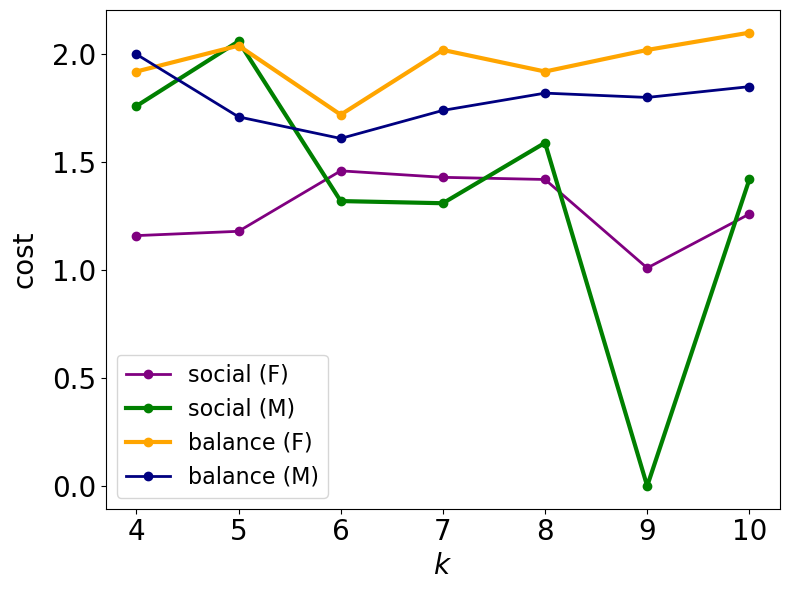

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
k_values = [4, 5, 6, 7, 8, 9, 10]
dist_fl_female = [1.16,1.18,1.46,1.43,1.42,1.01,1.26]
dist_fl_male = [1.76,2.06,1.32,1.31,1.59,0.0,1.42]
dist_b_female = [1.92,2.04,1.72,2.02,1.92,2.02,2.1]
dist_b_male = [2.0,1.71,1.61,1.74,1.82,1.8,1.85]

# Plot
plt.figure(figsize=(8,6))

plt.plot(k_values, dist_fl_female, color='purple', marker='o', label='social (F)', linewidth=2)
plt.plot(k_values, dist_fl_male, color='green', marker='o', label='social (M)', linewidth=3)
plt.plot(k_values, dist_b_female, color='orange', marker='o', label='balance (F)', linewidth=3)
plt.plot(k_values, dist_b_male, color='navy', marker='o',label='balance (M)', linewidth=2)

# Axis labels
plt.xlabel(r"$k$",fontsize=20)
plt.ylabel("cost", labelpad=10,fontsize=20)

# Tick sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Legend
plt.legend(fontsize=16)

# Layout
plt.tight_layout()
plt.savefig("dist_balance_fl_adult.pdf")
plt.show()


In [149]:
feature_cols = ['age', 'final-weight', 'education-num','marital-status','occupation','relationship', 'capital-gain', 'hours-per-week','native-country','income']

feature_changes = []

for (unfair_label, fair_label), factual_array in misclassified_by_transition.items():
    cfes = cfes_lists[(unfair_label, fair_label)]
    
    for factual, cf in zip(factual_array[:,:-1], cfes):
        diff = np.abs(cf - factual)
        feature_changes.append(diff)

feature_changes = np.array(feature_changes)
avg_change = np.mean(feature_changes, axis=0)

df_feature_change = pd.DataFrame({
    "Feature":feature_cols ,
    "Avg Absolute Change": avg_change
}).sort_values("Avg Absolute Change", ascending=False)


In [153]:
#df_balance = pd.read_csv('df_balance.csv')
feature_cols = ['age', 'final-weight', 'education-num','marital-status','occupation','relationship', 'capital-gain', 'hours-per-week','native-country','income']
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

changed = df_factuals_counterfactuals[cf_feature_cols].values != df_factuals_counterfactuals[feature_cols].values
change_counts = changed.sum(axis=0)

squared_diffs = (df_factuals_counterfactuals[cf_feature_cols].values - df_factuals_counterfactuals[feature_cols].values) ** 2

total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

# Step 4: Average contribution of each feature to total distance
avg_contributions = contributions.mean(axis=0)

# Step 5: Combine into a summary DataFrame
feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]
feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)


In [157]:
df_female = df_factuals_counterfactuals[df_factuals_counterfactuals['gender']==0]
df_male = df_factuals_counterfactuals[df_factuals_counterfactuals['gender']==1]

# df_female_balance = df_balance[df_balance['sex']==0]
# df_male_balance = df_balance[df_balance['sex']==1]

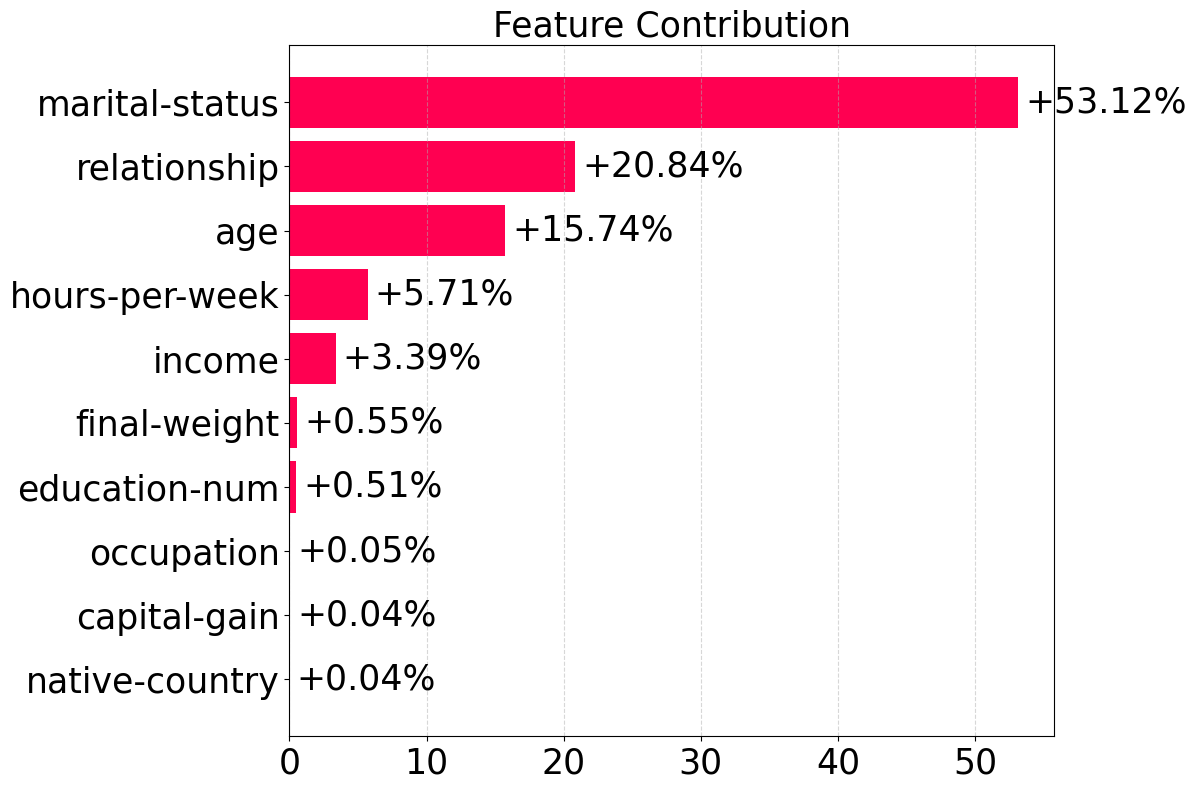

In [159]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

bars = plt.barh(
    feature_summary["Feature"], 
    feature_summary["Avg Contribution (%)"], 
    color="#FF0051"
)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}%", va='center', fontsize=25)


plt.title("Feature Contribution", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


# Grid and layout
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save to PDF
plt.savefig("feature_contribution_plot_fair_lloyd.pdf", format="pdf", bbox_inches="tight")

# Show plot
plt.show()


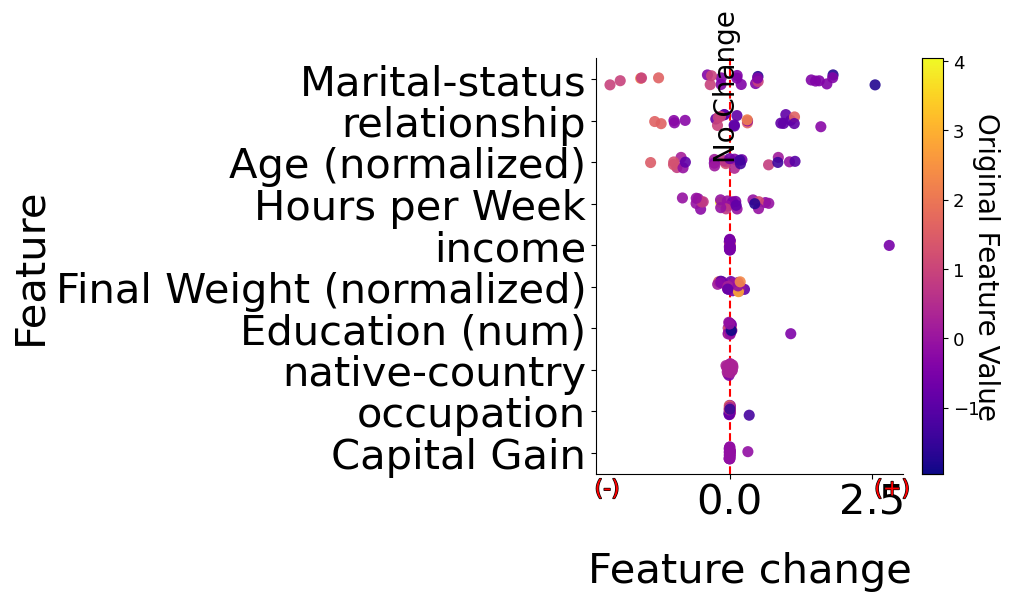

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects

feature_labels = {
    'age': 'Age (normalized)',
    'final-weight': 'Final Weight (normalized)',
    'education-num': 'Education (num)',
    'marital-status': 'Marital-status',
    'occupation':'occupation',
    'relationship':'relationship',
    'capital-gain': 'Capital Gain',
    'native-country':'native-country',
    'income':'income',
    'hours-per-week': 'Hours per Week'
}
features = list(feature_labels.keys())
records = []
for feature in features:
    factual_values = df_factuals_counterfactuals[feature].values
    cf_values = df_factuals_counterfactuals[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

# Convert to DataFrame
df = pd.DataFrame(records)
df['Feature'] = df['Feature'].map(feature_labels)

feature_order = (
    df.groupby("Feature")["Delta"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index
    .tolist()
)

cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

# Plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=8, alpha=0.9,
    order=feature_order  # dynamic order
)
# Colorbar setup
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Original Feature Value", rotation=270, labelpad=15, fontsize=20)
cbar.ax.tick_params(labelsize=13)

# Labels
ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

decrease_text = ax.text(df['Delta'].min() - 0.05, ax.get_ylim()[0] + 0.65, '(-)',
                        ha='center', va='bottom', fontsize=16, color='red')
increase_text = ax.text(df['Delta'].max() + 0.05, ax.get_ylim()[0] + 0.65, '(+)',
                        ha='center', va='bottom', fontsize=16, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])

# Vertical zero line and annotation
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=20, color='black', rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig("explainability_fair.pdf", format="pdf", bbox_inches="tight")

plt.show()


### FEMALE EXPLANATIONS

In [169]:

feature_cols = ['age', 'final-weight', 'education-num','marital-status','occupation','relationship', 'capital-gain', 'hours-per-week','native-country','income']
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

changed = df_female[cf_feature_cols].values != df_female[feature_cols].values
change_counts = changed.sum(axis=0)

squared_diffs = (df_female[cf_feature_cols].values - df_female[feature_cols].values) ** 2
total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

avg_contributions = contributions.mean(axis=0)

feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]
feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)


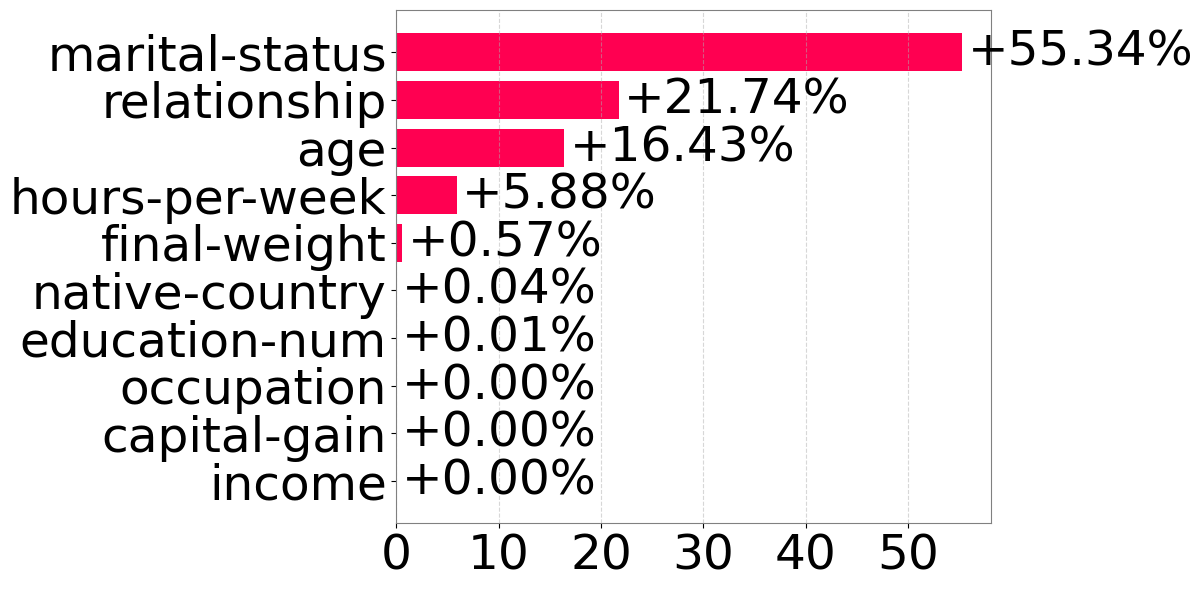

In [171]:

plt.figure(figsize=(12, 6))

bars = plt.barh(
    feature_summary["Feature"], 
    feature_summary["Avg Contribution (%)"], 
    color="#FF0051"
)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}%", va='center', fontsize=35)

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)

for spine in plt.gca().spines.values():
    spine.set_edgecolor("gray")

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig("feature_contribution_plot_fair_lloyd_female.pdf", format="pdf", bbox_inches="tight")
plt.savefig("feature_contribution_plot_balance_female.pdf", format="pdf", bbox_inches="tight")
plt.show()


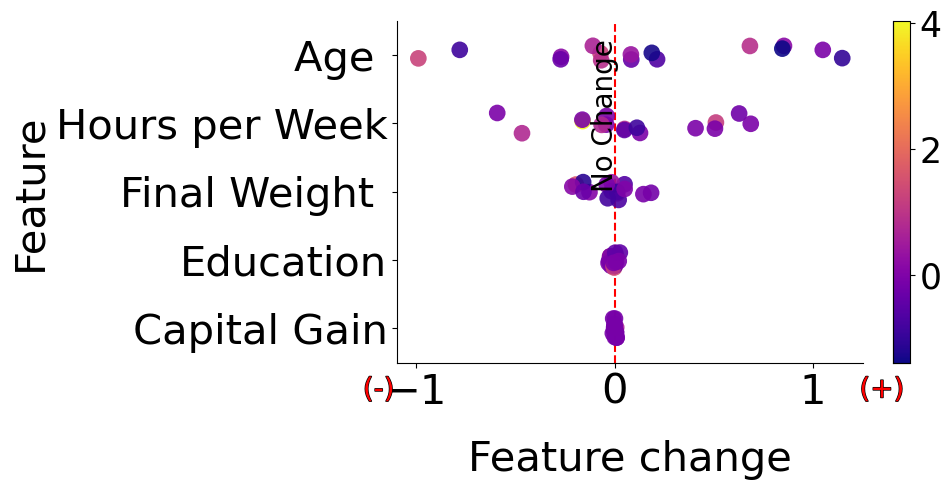

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects

feature_labels = {
    'age': 'Age ',
    'final-weight': 'Final Weight ',
    'education-num': 'Education',
    'capital-gain': 'Capital Gain',
    'hours-per-week': 'Hours per Week'
}
features = list(feature_labels.keys())
records = []
for feature in features:
    factual_values = df_female[feature].values
    cf_values = df_female[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

df = pd.DataFrame(records)
df['Feature'] = df['Feature'].map(feature_labels)

feature_order = (
    df.groupby("Feature")["Delta"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index
    .tolist()
)

cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

# Plot
plt.figure(figsize=(10, 5))

ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=12, alpha=0.9,
    order=feature_order  
)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=25)

ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

decrease_text = ax.text(df['Delta'].min() - 0.2, ax.get_ylim()[0] + 0.6, '(-)',
                        ha='center', va='bottom', fontsize=20, color='red')
increase_text = ax.text(df['Delta'].max() + 0.2, ax.get_ylim()[0] + 0.6, '(+)',
                        ha='center', va='bottom', fontsize=20, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])

ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=20, color='black', rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig("explainability_fair_lloyd_female.pdf", format="pdf", bbox_inches="tight")
#plt.savefig("explainability_balance_female.pdf", format="pdf", bbox_inches="tight")

plt.show()


### EXPLANATIONS MALE

In [175]:

changed = df_male[cf_feature_cols].values != df_male[feature_cols].values
change_counts = changed.sum(axis=0)

squared_diffs = (df_male[cf_feature_cols].values - df_male[feature_cols].values) ** 2
total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

avg_contributions = contributions.mean(axis=0)

feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]
feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)


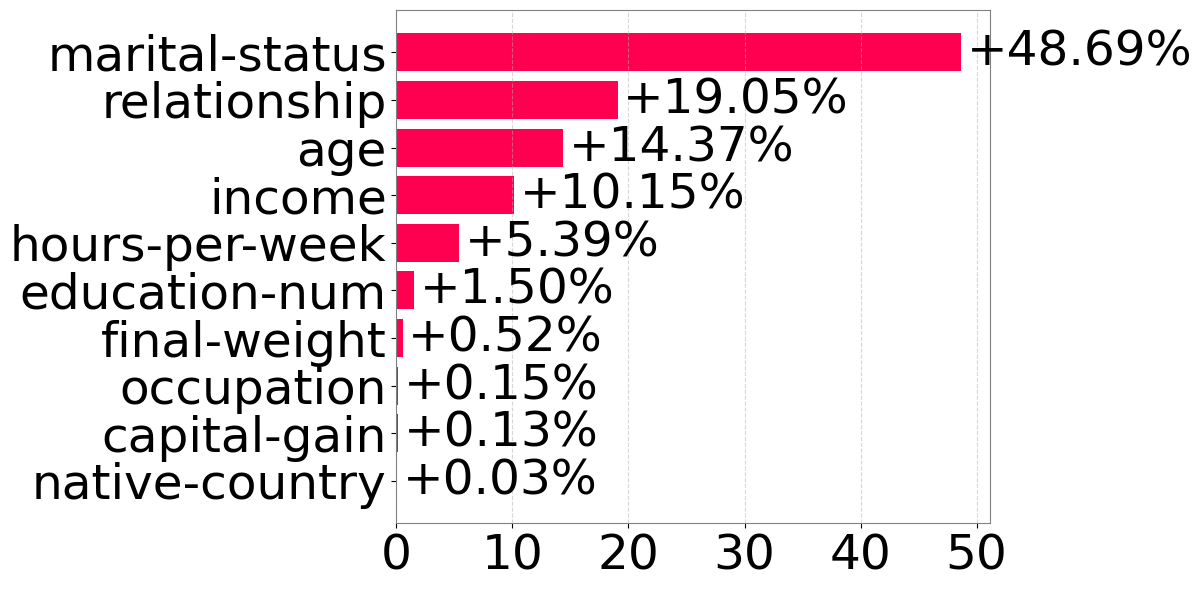

In [179]:
plt.figure(figsize=(12, 6))

bars = plt.barh(
    feature_summary["Feature"], 
    feature_summary["Avg Contribution (%)"], 
    color="#FF0051"
)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}%", va='center', fontsize=35)

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)

for spine in plt.gca().spines.values():
    spine.set_edgecolor("gray")

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

#plt.savefig("feature_contribution_plot_balance_male.pdf", format="pdf", bbox_inches="tight")
plt.savefig("feature_contribution_plot_fair_lloyd_male.pdf", format="pdf", bbox_inches="tight")

# Show plot
plt.show()


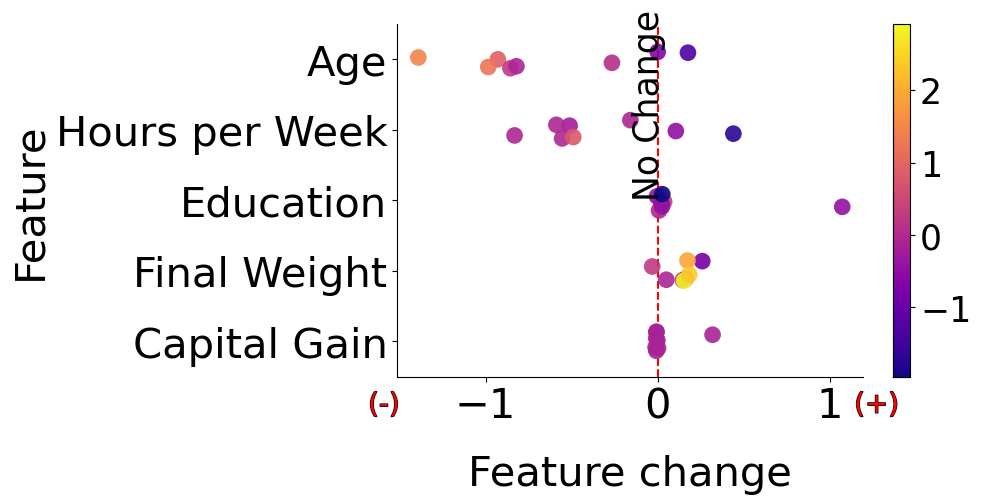

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects

feature_labels = {
    'age': 'Age',
    'final-weight': 'Final Weight',
    'education-num': 'Education',
    'capital-gain': 'Capital Gain',
    'hours-per-week': 'Hours per Week'
}
features = list(feature_labels.keys())
records = []
for feature in features:
    factual_values = df_male[feature].values
    cf_values = df_male[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

df = pd.DataFrame(records)
df['Feature'] = df['Feature'].map(feature_labels)

feature_order = (
    df.groupby("Feature")["Delta"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index
    .tolist()
)

cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

plt.figure(figsize=(10, 5))
ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=12, alpha=0.9,
    order=feature_order 
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=25)

ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

decrease_text = ax.text(df['Delta'].min() - 0.2, ax.get_ylim()[0] + 0.6, '(-)',
                        ha='center', va='bottom', fontsize=20, color='red')
increase_text = ax.text(df['Delta'].max() + 0.2, ax.get_ylim()[0] + 0.6, '(+)',
                        ha='center', va='bottom', fontsize=20, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])

ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=25, color='black', rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig("explainability_fair_lloyd_male.pdf", format="pdf", bbox_inches="tight")
#plt.savefig("explainability_male.pdf", format="pdf", bbox_inches="tight")

plt.show()
